In [ ]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from ipywidgets import interact
import scipy.stats as stats
import pandas as pd
# import pymc3 as pm
import arviz as az
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

import warnings # the warning spam is pointless and annoying
warnings.simplefilter(action="ignore", category=FutureWarning)

Populating the interactive namespace from numpy and matplotlib


# State space models
Let us continue with our example about tracking polar bears. Suppose we now have data from a tracking collar of one of our bears. The GPS measurements that come from the collar are samples at equal time intervals of 1 hour. Our collar measurements will be given by
$$ z_{k} \sim \text{Normal}(x_{k}, \sigma_{\rm obs}),$$
where $x_{k}$ is the actual position of the bear at times $t_k = k$. We will model the actual position of the bear as a simple random walk
$$ x_k \sim \text{Normal}(x_{k-1}, \sigma)$$

The full generative model is then
\begin{align}
  z_{k} &\sim \text{Normal}(x_{k}, \sigma_{\rm obs}) \\
   x_k &\sim \text{Normal}(x_{k-1}, \sigma) \\
   x_0 & \sim  \text{Normal}(0, 25)\\
   \sigma_{\rm obs} &\sim ??? \\
   \sigma &\sim ???
\end{align}

## State space model in Tensorflow
First, we will sample the posterior
$$\pi(x_0, x_1, \ldots, x_T | z_1, \ldots, z_T; \theta) \propto \prod_{k=1}^{T}g(z_k| x_k)f(x_k | x_{k-1})p_0(x_0)$$
The generative model is
$$p(x_0, x_1, \ldots, x_T, z_1, \ldots, z_T | \theta) = \prod_{k=1}^{T}g(z_k| x_k)f(x_k | x_{k-1})p_0(x_0)$$


### (See also previous results in the Week 12 notebook)

# Expectation Maximization Algorithm
We want to compute the log likelihood $\mathcal{L}(\theta)$ of the parameters $\theta$ so that we can obtain the maximum likelihood estimator
  $$\theta_{MLE} =  \text{arg max}_{\theta}\mathcal{L}(\theta).$$




$$ \mathcal{L}(\theta) = \log(\int dx_0 \cdots \int dx_T p(x_0, x_1, \ldots, x_T, z_1, \ldots, z_T | \theta) )$$

$$\pi(x_0, x_1, \ldots, x_T | z_1, \ldots, z_T; \theta) = \frac{\prod_{k=1}^{T}g(z_k| x_k)f(x_k | x_{k-1})p_0(x_0)}{\int dx_0 \cdots \int dx_T \prod_{k=1}^{T}g(z_k| x_k)f(x_k | x_{k-1})p_0(x_0)}$$

  1. E-step: given fixed parameters $\theta_j$ sample
  $$ X_{1:T} \mid z_{1:T}, \theta_j$$
  Then compute the expectation
  \begin{align}
  Q(\theta | \theta_j) &= E[\log(\prod_{k=1}^{T}g(z_k| X_k, \theta)f(X_k | X_{k-1}, \theta)p_0(X_0|\theta)) \mid \theta_j]\\
  &= E[\sum_{k=1}^{T}\log(g(z_k| X_k, \theta)) + \sum_{k=1}^{T}\log(f(X_k | X_{k-1}, \theta)) + \log(p_0(X_0|\theta)) \mid \theta_j]
  \end{align}
  2. M-step: compute $$\theta_{j+1} = \text{arg max}_{\theta} Q(\theta | \theta_j)  $$
  
Repeat these steps until convergence is reached.

# Expectation Maximization with Tensorflow gradient descent
Suppose we want to estimate the bear's mobility parameter $\sigma$

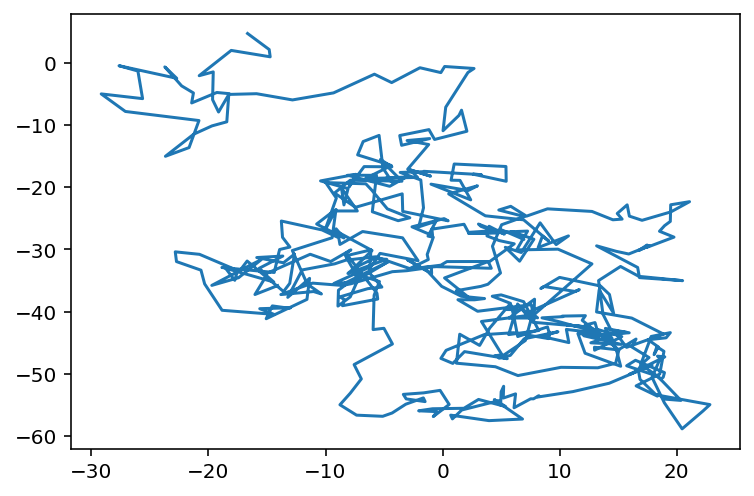

In [ ]:
Nt = 500 ## number of measured positions from bear's trackinkg collar

X0true = -25. + 50.*rand(1, 2) ## bear's initial position
Xtrue = X0true + normal(0, 2., [Nt, 2]).cumsum(axis=0) ## bear's true path
Z = Xtrue + normal(0, 0.2, [Nt, 2]) ## add observation error to the path
plot(Z[:, 0], Z[:, 1]);

In [ ]:
Nsteps = 10 ## number of MCMC steps
N_burn_in = 50
Nchains = 8

log_sigma_obs = tf.Variable(log(1.), dtype=tf.float64)
log_sigma = tf.Variable(log(5.), dtype=tf.float64)

@tf.function()
def log_target_density(Xfull):
    ## Xfull must be a three dimensional array 
    Sigma_obs = tf.math.exp(log_sigma_obs)*tf.ones([1, 1, 2], dtype=tf.float64)
    ## tensorflow variable appears here
    Sigma = tf.math.exp(log_sigma)*tf.ones([1, 1, 2], dtype=tf.float64) 
    Sigma_x0 = 100*tf.ones([1, 2], dtype=tf.float64)
    ## X : [parallel chains, time, space]
    X0 = Xfull[:, 0, :]
    X = Xfull[:, 1:, :] ## same shape as `Z`
    ## observation likelihood: density for Z given X
    G = tfd.MultivariateNormalDiag(
        loc=X, 
        scale_diag=Sigma_obs)
    logG = tf.reduce_sum(
        G.unnormalized_log_prob(Z),
        axis=1)
    ## motion model: density for X
    F = tfd.MultivariateNormalDiag(
        loc=Xfull[:, :-1, :], 
        scale_diag=Sigma)
    logF = tf.reduce_sum(
        F.unnormalized_log_prob(X),
        axis=1)
    ## initial position prior: density for X0
    F0 = tfd.MultivariateNormalDiag(
        loc=tf.zeros([1, 2], dtype=tf.float64), 
        scale_diag=Sigma_x0)
    logF0 = F0.unnormalized_log_prob(X0)
    return logG + logF + logF0


In [ ]:
@tf.function()
def track_sampler(Xinit):
    kernel = tfp.mcmc.NoUTurnSampler(
        target_log_prob_fn=log_target_density,
        max_tree_depth=8,
        max_energy_diff=1000,
        step_size=tf.cast(0.1, tf.float64))

    adaptive_kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        inner_kernel=kernel,
        num_adaptation_steps=int(0.8 * N_burn_in),
        target_accept_prob=tf.cast(0.7, tf.float64))
    
    Xchain = tfp.mcmc.sample_chain(
        num_results=Nsteps,
        num_burnin_steps=N_burn_in,
        current_state=Xinit,
        #trace_fn=trace_everything,
        trace_fn=None,
        kernel=adaptive_kernel,
        parallel_iterations=4)
    return Xchain

In [ ]:
## Estep

def Estep():
    Xinit = zeros([Nchains, Nt+1, 2])
    Xinit[:, 0, :] = normal(0, 25., [Nchains, 2])
    Xinit[:, 1:, :] = Z + normal(0, 5., [Nchains, Nt, 2])
    Xchain = track_sampler(Xinit)
    Xchain = array(Xchain)
    return Xchain ## [MCMC steps, parallel chains, time, space]
@tf.function()
def averaged_log_density():
    return tf.reduce_mean(log_target_density(Xchain.reshape(-1, Nt+1, 2)))

In [ ]:
## M step

N_gd_steps = 10
# learning_rate = 0.001
# optimizer = tf.optimizers.SGD(learning_rate=learning_rate)
learning_rate = 0.01
optimizer = tf.optimizers.Adam(learning_rate=learning_rate)

trainable_variables = [log_sigma, log_sigma_obs]
@tf.function()
def Mstep(Xchain):
    loss = tf.constant(0., dtype=tf.float64)
    for _ in tf.range(N_gd_steps):
        with tf.GradientTape() as tape:
            ## must tell Tensorflow what trainable variables to use for 
            ## gradients
            tape.watch(trainable_variables)
            ## we use the negative averaged log likelihood because our 
            ## optimizer is set up to solve mimimization
            loss = -averaged_log_density()
        ## compute the gradient of the loss
        grad = tape.gradient(loss, trainable_variables)
        ## this takes one step of gradient descent to change the trainable 
        ## prameters
        optimizer.apply_gradients( 
            zip(grad, trainable_variables))
        ## Note that the values stored in the trainable variable object changes 
        ## as a result of this operation
    return loss

In [ ]:
log_sigma.assign(log(4.)), log_sigma_obs.assign(log(0.1))
print('sigma:', exp(log_sigma), 'sigma_obs:', exp(log_sigma_obs))
for _ in arange(10):
    Xchain = Estep()
    loss = Mstep(Xchain)
    print('loss:', array(loss))
    print('sigma:', exp(log_sigma), 'sigma_obs:', exp(log_sigma_obs))

sigma: 4.0 sigma_obs: 0.10000000000000002
loss: 4491.916551124594
sigma: 3.716253648974166 sigma_obs: 0.1188342649331675
loss: 3539.0156385701775
sigma: 3.29980151024446 sigma_obs: 0.1438357578033359
loss: 3020.776776848029
sigma: 2.922243023958905 sigma_obs: 0.16723689149435864
loss: 2743.580971032723
sigma: 2.6197676396234217 sigma_obs: 0.18688944485227846
loss: 2590.3514533351445
sigma: 2.3921184464462306 sigma_obs: 0.202848642580912
loss: 2503.4821482992297
sigma: 2.230423956534621 sigma_obs: 0.2158529209407091
loss: 2453.0874754752235
sigma: 2.123701962063079 sigma_obs: 0.2266435598992937
loss: 2422.553834934196
sigma: 2.060074366069413 sigma_obs: 0.23578044381199925
loss: 2402.760376505583
sigma: 2.0274529949123816 sigma_obs: 0.24364823396331345
loss: 2389.0566413753054
sigma: 2.0146843706493964 sigma_obs: 0.25050585277768694
